## Installing Dependencies

In [2]:
!pip install torch torchvision torchaudio
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.0.0+cpu.html
!pip install torch-geometric
!pip install torch networkx scikit-learn sentence-transformers spacy
!python -m spacy download en_core_web_sm

Looking in links: https://data.pyg.org/whl/torch-2.0.0+cpu.html
  Using cached numpy-2.0.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (60 kB)
Using cached numpy-2.0.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (19.5 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.6.0 requires sentencepiece, which is not installed.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 20.8 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
!pip install numpy==1.26.4


  Using cached numpy-1.26.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.2 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.6.0 requires sentencepiece, which is not installed.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.26.4 which is incompatible.


## Imports

In [4]:
import json
import torch
import spacy
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import from_scipy_sparse_matrix, negative_sampling
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from scipy.sparse import lil_matrix

# Load models
nlp = spacy.load("en_core_web_sm")
embedder = SentenceTransformer("all-MiniLM-L6-v2")

/DATA/vikash_2101cs82/miniconda3/envs/vikenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/DATA/vikash_2101cs82/miniconda3/envs/vikenv/lib/python3.9/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/DATA/vikash_2101cs82/miniconda3

In [6]:


# ========== Data Processing ==========
def get_edges_and_labels(dialogue, clause_indices):
    edges = []
    for i, turn in enumerate(dialogue):
        if "emotion" in turn and turn["emotion"] != "neutral":
            if "expanded emotion cause evidence" in turn:
                for j in turn["expanded emotion cause evidence"]:
                    try:
                        cause_turn = int(str(j).strip()) - 1
                        if cause_turn in clause_indices and i in clause_indices:
                            from_idx = clause_indices[i]
                            to_idx = clause_indices[cause_turn]
                            edges.append((from_idx, to_idx))
                    except ValueError:
                        continue
    return edges

def process_dialogue(dialogue):
    clauses = []
    clause_turn_map = {}
    turn_clause_indices = {}
    clause_idx = 0

    for i, turn in enumerate(dialogue):
        doc = nlp(turn["utterance"])
        turn_clause_indices[i] = []
        for sent in doc.sents:
            clause_text = sent.text.strip()
            if clause_text:
                clauses.append(clause_text)
                clause_turn_map[clause_idx] = i
                turn_clause_indices[i].append(clause_idx)
                clause_idx += 1

    if not clauses:
        return None

    embeddings = embedder.encode(clauses)
    x = torch.tensor(embeddings, dtype=torch.float)

    pos_edges = get_edges_and_labels(dialogue, {v: k for k, v in clause_turn_map.items()})
    
    # Build undirected graph
    adj = lil_matrix((len(clauses), len(clauses)))
    for i in range(len(clauses)):
        for j in range(i + 1, len(clauses)):
            if has_grammatical_connection(clauses[i], clauses[j]):
                adj[i, j] = 1
                adj[j, i] = 1

    edge_index, _ = from_scipy_sparse_matrix(adj)
    return Data(x=x, edge_index=edge_index, pos_edge_index=torch.tensor(pos_edges).t() if pos_edges else None)

def has_grammatical_connection(a, b):
    doc_a = nlp(a)
    doc_b = nlp(b)
    ents_a = {ent.text.lower() for ent in doc_a.ents}
    ents_b = {ent.text.lower() for ent in doc_b.ents}
    if ents_a & ents_b:
        return True
    return any(
        t1.text.lower() == t2.text.lower() and t1.dep_ in ("nsubj", "dobj")
        for t1 in doc_a for t2 in doc_b
    )


## Load Dataset

In [ ]:

# ========== Load Dataset ==========
def load_data(path):
    with open(path) as f:
        data = json.load(f)
    return [process_dialogue(conv[0]) for conv in data.values() if conv]

train_data = [d for d in load_data("/DATA/vikash_2101cs82/temp_folder/nlp/dailydialog_train.json") if d]
test_data = [d for d in load_data("/DATA/vikash_2101cs82/temp_folder/nlp/dailydialog_test.json") if d]
val_data= [d for d in load_data("/DATA/vikash_2101cs82/temp_folder/nlp/dailydialog_valid.json") if d]


## Model Classifier

In [7]:

# ========== Model ==========
class GCNLinkPredictor(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

model = GCNLinkPredictor(in_channels=384, hidden_channels=128, out_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.BCEWithLogitsLoss()

## Train and Validate

In [1]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
import copy

# ========== Training & Evaluation ==========
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1s = []

best_val_f1 = 0
best_model_state = None

for epoch in range(20):
    # Training
    model.train()
    total_loss = 0
    total_preds = []
    total_trues = []

    for data in train_data:
        if data.pos_edge_index is None:
            continue

        optimizer.zero_grad()
        z = model(data.x, data.edge_index)

        # Positive edges
        pos_edges = data.pos_edge_index
        pos_pred = (z[pos_edges[0]] * z[pos_edges[1]]).sum(dim=1)

        # Negative edges
        neg_edges = negative_sampling(
            edge_index=data.edge_index,
            num_nodes=data.num_nodes,
            num_neg_samples=pos_edges.size(1)
        )
        neg_pred = (z[neg_edges[0]] * z[neg_edges[1]]).sum(dim=1)

        # Loss
        pred = torch.cat([pos_pred, neg_pred])
        true = torch.cat([torch.ones_like(pos_pred), torch.zeros_like(neg_pred)])
        loss = criterion(pred, true)

        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        pred_binary = (pred.sigmoid() > 0.5).int().cpu().numpy()
        true_binary = true.int().cpu().numpy()
        total_preds.extend(pred_binary)
        total_trues.extend(true_binary)

    avg_train_loss = total_loss / len(train_data)
    train_acc = accuracy_score(total_trues, total_preds)
    train_losses.append(avg_train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    val_loss = 0
    val_preds = []
    val_trues = []

    with torch.no_grad():
        for data in val_data:
            if data.pos_edge_index is None:
                continue

            z = model(data.x, data.edge_index)
            pos_edges = data.pos_edge_index
            pos_pred = (z[pos_edges[0]] * z[pos_edges[1]]).sum(dim=1).sigmoid()

            neg_edges = negative_sampling(
                edge_index=data.edge_index,
                num_nodes=data.num_nodes,
                num_neg_samples=pos_edges.size(1)
            )
            neg_pred = (z[neg_edges[0]] * z[neg_edges[1]]).sum(dim=1).sigmoid()

            pred = torch.cat([pos_pred, neg_pred])
            true = torch.cat([torch.ones_like(pos_pred), torch.zeros_like(neg_pred)])

            loss = criterion(pred, true)
            val_loss += loss.item()

            pred_binary = (pred > 0.5).int().cpu().numpy()
            true_binary = true.int().cpu().numpy()

            val_preds.extend(pred_binary)
            val_trues.extend(true_binary)

    avg_val_loss = val_loss / len(val_data)
    val_acc = accuracy_score(val_trues, val_preds)
    val_f1 = f1_score(val_trues, val_preds, zero_division=0)

    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)
    val_f1s.append(val_f1)

    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_model_state = copy.deepcopy(model.state_dict())

    print(f"Epoch {epoch+1:02d} | "
          f"Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.4f} | "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")


NameError: name 'model' is not defined

## Load Model and Test 

In [9]:

# ========== Load best model and test ==========
model.load_state_dict(best_model_state)
model.eval()

test_preds = []
test_trues = []
test_probs = []

with torch.no_grad():
    for data in test_data:
        if data.pos_edge_index is None:
            continue

        z = model(data.x, data.edge_index)
        pos_edges = data.pos_edge_index
        pos_pred = (z[pos_edges[0]] * z[pos_edges[1]]).sum(dim=1).sigmoid()

        neg_edges = negative_sampling(
            edge_index=data.edge_index,
            num_nodes=data.num_nodes,
            num_neg_samples=pos_edges.size(1)
        )
        neg_pred = (z[neg_edges[0]] * z[neg_edges[1]]).sum(dim=1).sigmoid()

        pred = torch.cat([pos_pred, neg_pred])
        true = torch.cat([torch.ones_like(pos_pred), torch.zeros_like(neg_pred)])

        pred_binary = (pred > 0.5).int().cpu().numpy()
        true_binary = true.int().cpu().numpy()

        test_preds.extend(pred_binary)
        test_trues.extend(true_binary)
        test_probs.extend(pred.cpu().numpy())

test_acc = accuracy_score(test_trues, test_preds)
test_f1 = f1_score(test_trues, test_preds, zero_division=0)
test_precision = precision_score(test_trues, test_preds, zero_division=0)
test_recall = recall_score(test_trues, test_preds, zero_division=0)
test_auc = roc_auc_score(test_trues, test_probs)

print("\n===== Test Set Evaluation (Best Val F1 Model) =====")
print(f"Test Accuracy:  {test_acc:.4f}")
print(f"Test F1 Score:  {test_f1:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall:    {test_recall:.4f}")
print(f"Test AUC:       {test_auc:.4f}")




===== Test Set Evaluation (Best Val F1 Model) =====
Test Accuracy:  0.6393
Test F1 Score:  0.7088
Test Precision: 0.5947
Test Recall:    0.8770
Test AUC:       0.7581


## Plots

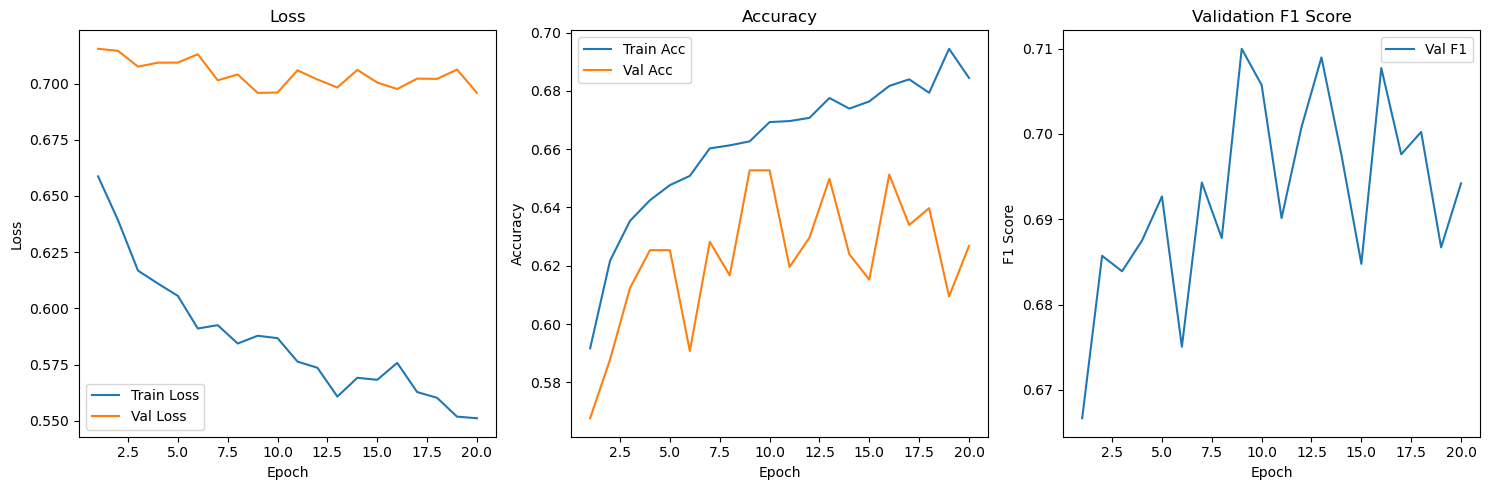

In [10]:
# ========== Plotting ==========
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(epochs, train_accuracies, label='Train Acc')
plt.plot(epochs, val_accuracies, label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(epochs, val_f1s, label='Val F1')
plt.title('Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()


## Sample Conversation Prediction

In [11]:
def predict_emotion_causes(model, conversation_key, threshold=0.5):
    """Predict and display emotion-cause pairs for a specific conversation key."""
    
    def load_conversation(key):
        try:
            file_path = "/DATA/vikash_2101cs82/temp_folder/nlp/dailydialog_test.json"
            with open(file_path) as f:
                data = json.load(f)
            
            conversations = data.get(str(key))
            if not conversations:
                print(f"No conversation found with key '{key}'")
                return None
            return conversations[0]
            
        except FileNotFoundError:
            print(f"Error: File not found at {file_path}")
            return None
        except Exception as e:
            print(f"Error loading data: {str(e)}")
            return None

    # Load conversation
    raw_conv = load_conversation(conversation_key)
    if not raw_conv:
        return

    # Process dialogue
    data = process_dialogue(raw_conv)
    if not data:
        print("No processable clauses found")
        return

    # Create clause-to-turn mapping
    clause_turn_map = {}
    turn_clauses = {}
    clause_idx = 0
    for turn_idx, turn in enumerate(raw_conv):
        doc = nlp(turn["utterance"])
        turn_clauses[turn_idx] = []
        for _ in doc.sents:
            clause_turn_map[clause_idx] = turn_idx
            turn_clauses[turn_idx].append(clause_idx)
            clause_idx += 1

    # Get predictions
    model.eval()
    with torch.no_grad():
        z = model(data.x, data.edge_index)
    
    # Find emotion clauses
    emotion_clauses = []
    for turn_idx, turn in enumerate(raw_conv):
        if "emotion" in turn and turn["emotion"] != "neutral":
            emotion_clauses.extend(turn_clauses.get(turn_idx, []))

    # Predict causes with error handling
    predicted_pairs = []
    for emo_clause in emotion_clauses:  # emo_clause is an INTEGER here
        scores = (z[emo_clause] * z).sum(dim=1).sigmoid()

        for cause_clause in scores.argsort(descending=True):  # cause_clause is a TENSOR
            # Convert only tensor indices to Python integers
            emo_idx = emo_clause  # Already an integer
            cause_idx = cause_clause.item()  # Convert tensor to int

            # Validate indices before lookup
            if (scores[cause_clause] > threshold and 
                cause_idx in clause_turn_map and 
                cause_idx < emo_idx and
                emo_idx in clause_turn_map):
                
                emo_turn = clause_turn_map[emo_idx] + 1
                cause_turn = clause_turn_map[cause_idx] + 1
                predicted_pairs.append((emo_turn, cause_turn))

    # Display conversation
    print(f"\n{'='*50}\nConversation Key: {conversation_key}")
    for turn_idx, turn in enumerate(raw_conv):
        print(f"\n[Turn {turn_idx+1}] {turn['utterance']}")
        if "emotion" in turn:
            print(f"  → Emotion: {turn['emotion'].upper()}")

    # Display predictions
    print(f"\n{'='*50}\nPredicted Emotion-Cause Pairs (threshold={threshold}):")
    seen = set()
    for emo, cause in predicted_pairs:
        if (emo, cause) not in seen:
            print(f"  Emotion at Turn {emo} ← Cause at Turn {cause}")
            
            seen.add((emo, cause))
    
    if not seen:
        print("  No pairs predicted above threshold")

# Example usage
predict_emotion_causes(model, "te_665")



Conversation Key: te_665

[Turn 1] Hi ! I'm happy you could make it .
  → Emotion: HAPPINESS

[Turn 2] Well , I've been looking forward to seeing you .
  → Emotion: HAPPINESS

[Turn 3] What can I get you ?
  → Emotion: HAPPINESS

[Turn 4] I'd love a gin and tonic .
  → Emotion: HAPPINESS

Predicted Emotion-Cause Pairs (threshold=0.5):
  Emotion at Turn 2 ← Cause at Turn 1
  Emotion at Turn 3 ← Cause at Turn 1
  Emotion at Turn 3 ← Cause at Turn 2
  Emotion at Turn 4 ← Cause at Turn 1
  Emotion at Turn 4 ← Cause at Turn 2
  Emotion at Turn 4 ← Cause at Turn 3


In [13]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.utils import from_scipy_sparse_matrix
from scipy.sparse import lil_matrix
from sentence_transformers import SentenceTransformer
import spacy

# Load NLP tools
nlp = spacy.load("en_core_web_sm")
embedder = SentenceTransformer("all-MiniLM-L6-v2")  # Or any model you use

# Dummy placeholder for grammatical connection function
def has_grammatical_connection(clause1, clause2):
    # Implement a real check here if needed
    return False

# Preprocess dialogue and build graph
def process_dialogue_for_prediction(dialogue):
    clauses = []
    clause_turn_map = {}  # {clause_idx: turn_idx}
    emotion_clause_indices = []

    for turn_idx, turn in enumerate(dialogue):
        utterance = turn.get("utterance", "")
        emotion = turn.get("emotion", "neutral").lower()

        # Clause segmentation
        doc = nlp(utterance)
        for sent in doc.sents:
            clause = sent.text.strip()
            if clause:
                clause_idx = len(clauses)
                clauses.append(clause)
                clause_turn_map[clause_idx] = turn_idx

                # If the turn is emotional, mark all its clauses
                if emotion != "neutral":
                    emotion_clause_indices.append(clause_idx)

    # Create syntactic graph adjacency matrix
    adj = lil_matrix((len(clauses), len(clauses)), dtype=np.float32)
    for i in range(len(clauses)):
        for j in range(i + 1, len(clauses)):
            if has_grammatical_connection(clauses[i], clauses[j]):
                adj[i, j] = 1.0
                adj[j, i] = 1.0

    edge_index, _ = from_scipy_sparse_matrix(adj.tocsr())

    # Clause embeddings
    embeddings = embedder.encode(clauses, convert_to_tensor=True)
    x = embeddings.to(torch.float)

    return Data(x=x, edge_index=edge_index), clauses, emotion_clause_indices

# Emotion-cause prediction function
def predict_emotion_cause_pairs(dialogue, model, threshold=0.9):
    data, clauses, emotion_clause_indices = process_dialogue_for_prediction(dialogue)

    # Match device
    device = next(model.parameters()).device
    data = data.to(device)

    model.eval()
    with torch.no_grad():
        z = model(data.x, data.edge_index)

    predicted_pairs = []
    for emotion_idx in emotion_clause_indices:
        scores = torch.matmul(z, z[emotion_idx])
        probabilities = torch.sigmoid(scores)

        for cause_idx, prob in enumerate(probabilities):
            if cause_idx != emotion_idx and prob > threshold:
                emotion_clause = clauses[emotion_idx]
                cause_clause = clauses[cause_idx]
                predicted_pairs.append((emotion_clause, cause_clause))

    return predicted_pairs

# Example usage
sample_dialogue = [
    {
        "utterance": "I'm really upset right now.",
        "emotion": "anger"
    },
    {
        "utterance": "What happened? You can tell me."
    },
    {
        "utterance": "My team lost the championship final today. We trained all year for this."
    },
    {
        "utterance": "I feel so anxious about tomorrow...",
        "emotion": "fear"
    },
    {
        "utterance": "Why? What's happening tomorrow?"
    },
    {
        "utterance": "I have to present to the executive board about the failed project."
    }
]

# Make sure your model is on the same device
model = model.to("cuda" if torch.cuda.is_available() else "cpu")

pairs = predict_emotion_cause_pairs(sample_dialogue, model)

# Output results
print("Predicted Emotion-Cause Pairs:")
for i, (emotion, cause) in enumerate(pairs, 1):
    print(f"\nPair {i}:")
    print(f"Emotion clause: {emotion}")
    print(f"Cause clause: {cause}")


Predicted Emotion-Cause Pairs:

Pair 1:
Emotion clause: I'm really upset right now.
Cause clause: You can tell me.

Pair 2:
Emotion clause: I'm really upset right now.
Cause clause: My team lost the championship final today.

Pair 3:
Emotion clause: I'm really upset right now.
Cause clause: I feel so anxious about tomorrow...

Pair 4:
Emotion clause: I feel so anxious about tomorrow...
Cause clause: I'm really upset right now.
